In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import glob
import os
import peakutils
import datetime
import warnings
import logging
from jupyterthemes import jtplot

In [2]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', size=6)

plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [3]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Cu_2p' : 5.321, 'Cl_2p' : 0.891})

In [4]:
def plot_regions(experiments : list, regions : list, colors : list = None):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / 3))
    cols = 3
    
    fig, ax = plt.subplots(rows, cols, figsize=(16, 8))
    for i,r in enumerate(regions):
        for c,xp in enumerate(experiments):
            j, k = i//3, i%3            
            if i == len(regions) - 1:   # Set labels from last region
                li = plot_region(xp, r, ax=ax[j][k], lb=xp.name)
                if len(colors) > 0: li.set_color(colors[c])
                ax[j][k].set_title('Au_4f')
                ax[j][k].get_legend().remove()
            else:
                li = plot_region(xp, r, ax=ax[j][k], lb='__nolabel__')
                if len(colors) > 0: li.set_color(colors[c])
                ax[j][k].set_title(r)
            cosmetics_plot(ax=ax[j][k], leg = False);
        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.tight_layout()
    fig.legend()

### Background subtraction class (dev) 

In [5]:
class Background2(object):
    @staticmethod
    def bg_handler(xp, region,  *args, **kwargs):
        x = xp.dfx[region].dropna().energy.values
        y = xp.dfx[region].dropna().counts.values
        return x, y

    @staticmethod
    def edit_xp(xp, region, x, y, ybg, ax = None):
        if ax == None: ax = plt.gca()
        col = plot_region(xp, region, lb=region, ax=ax).get_color()
        ax.plot(x, ybg, '--', color=col, label='__nolabel__')
        cosmetics_plot(ax=ax)
        
        dfnew = pd.DataFrame({'energy' : x, 'counts' : y - ybg})
        xpNew = deepcopy(xp)
        xpNew.dfx[region] = dfnew
        return xpNew

    def dec_linear(self, xp, region, *args, **kwargs):
        x, y = self.bg_handler(xp, region, *args, **kwargs)

        ybg = peakutils.baseline(y, deg=1)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_shirley(self, xp, region, maxit=40, **kwargs):
        kwargs['maxit'] = maxit
        x,y = self.bg_handler(xp, region, **kwargs)
        ybg = shirley_loop(x,y, **kwargs)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_2shirley(self, xp, region, xlim, maxit=40, **kwargs):
        x, y = self.bg_handler(xp, region, **kwargs)
        y1 = y[ x >= xlim ]
        x1 = x[ x >= xlim ]
        y2 = y[ x <= xlim ]
        x2 = x[ x <= xlim ]

        ybg1 = shirley_loop(x1, y1, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg2 = shirley_loop(x2, y2, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg = np.append(np.append(ybg1[:-1], np.average([ybg1[-1], ybg2[0]])), ybg2[1:] )
        return self.edit_xp(xp, region, x, y, ybg, **kwargs)

NameError: name 'trim_exps' is not defined

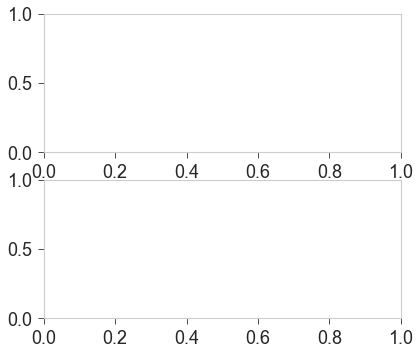

In [6]:
# Background2().dec_linear(xp=experiments[0], region='C_1s')
fig, ax = plt.subplots(2)
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
bg2 = BG2.dec_linear(xp=trim_exps[0], 
                     region='overview_', ax=ax[1])

In [ ]:
def test_bg_subpots()
    fig, ax = plt.subplots(2)
    BG2 = Background2()
    bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                           xlim = 346, maxit=50, ax=ax[0])
    bglin = BG2.dec_linear(xp=trim_exps[0], 
                         region='overview_', ax=ax[1])

    assert len(ax[0].get_lines()) <= 2, "Too many lines in lin_bg subplot"
    assert len(ax[0].get_lines()) >= 2, "Not enough lines in lin_bg subplot"

In [ ]:
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


In [ ]:
BG2 = Background2()
bg2 = BG2.dec_linear(xp=trim_exps[0], region='overview_')
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


In [ ]:
def test_method(method):
    BG2 = Background2()
    bg2 = method(xp=trim_exps[0], region='overview_')
    x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
    x,ybg = BG2.bg_handler(bg2, region='overview_')
    lentest = len(np.where(y < ybg)[0])
    assert lentest == 0, "Background over signal in %i points"%lentest
test_method(Background2().dec_linear)

## Pre-processing of data FBI on Cu policrystal
1- ALI injections 1 bar, 0.1 mM (19.06.2020)

## Import data

In [5]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/**/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if (' ' not in f) and ('/proc' not in f):
        files_new.append(f)
files_new.pop(2)
files_new.pop(3)

files = files_new
for f in files:
    print(os.path.split(f)[1])

18062020_Cu_clean.xy
19062020_Cu_FBI_100pulses_1e-4M.xy
20200628_Cu_FBI_100pulses_1e-4M_BaClO42_1e-4M.xy
20200702_Cu_FBI_200pulses_1e-4M.xy
20200706_Cu_FBI_200pulses_1e-4M_BaClO42_1e-4M_200pulses.xy
20200716_Cu_FBI_400pulses_1e-4M.xy
20200814_Cu_FBI_ester_200pulses_1e-4M.xy
20200814_Cu_FBI_ester_200pulses_1e-4M_BaClO42_45min.xy
20200922_Cu_clean2.xy
20200923_Cu_FBI_subl_20min.xy


In [6]:
find_groups(files[1])

1

In [33]:
names = ['Cu_clean', 'FBI_100_pulses', 'FBI_Ba_100_pulses', 'FBI_200_pulses', 'FBI_Ba_200_pulses', 'FBI_400_pulses',
         'FBI-ester_200_pulses', 'FBI-ester_200_pulses_Ba_subl', 'Cu_clean2', 'FBI_subl_20mins']
label = ['Cu clean', 'FBI 100pulses, 1000mbar GAr', 'FBI Ba(ClO4)2 100pulses, 1000mbar GAr', 
         'FBI 200pulses, 1000mbar GAr', 'FBI Ba(ClO4)2 200pulses, 1000mbar GAr', 'FBI 400pulses, 1000mbar GAr',
         'FBI-ester 200pulses', 'FBI-ester 200pulses; Ba subl 45 min', 'Cu clean 2', 'FBI sublimation 20 mins']

experiments = [xps_data_import(path=f, name=n, label=l) for f,n,l in zip(files, names, label)]
experiments[1].name

'FBI_100_pulses'

## Bg subtraction

In [15]:
region = 'Cu_2p'

Cu_clean
FBI_100_pulses
FBI_Ba_100_pulses
FBI_200_pulses
FBI_Ba_200_pulses
FBI_400_pulses
FBI-ester_200_pulses
FBI-ester_200_pulses_Ba_subl
Cu_clean2
FBI_subl_20mins


Text(0.5, 1.0, 'Cu 2p')

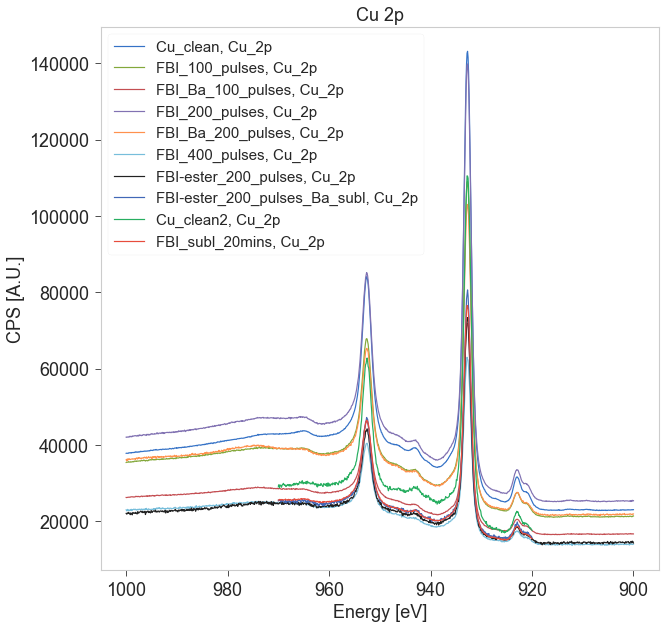

In [34]:
plt.figure(figsize=(10,10))
for xp in experiments:
    print(xp.name)
    plot_region(xp, region)
# plt.xlim(70, 100)
# plt.ylim(1.5e5, 4e5)
cosmetics_plot()
plt.title('Cu 2p')

/Users/pabloherrero/sabat/sabatsw/xps/xps_analysis.py:61: RuntimeWarning: invalid value encountered in greater
  dropup = np.where(xp.dfx[region].energy.values > eup)[0]


Text(0.5, 1.0, 'Cu 2p')

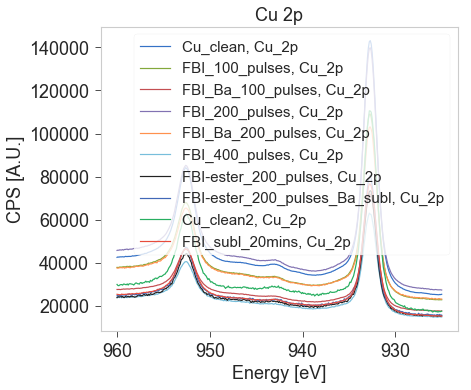

In [36]:
trim_exps = []
# for xp in experiments[:3]+experiments[4:]:
for xp in experiments:
    xp_new = crop_spectrum(xp, region=region, eup=960, edw=925)
    trim_exps.append(xp_new)
    plot_region(xp_new, region)
cosmetics_plot()
plt.title('Cu 2p')

### Subtract double shirley to all Cu regions

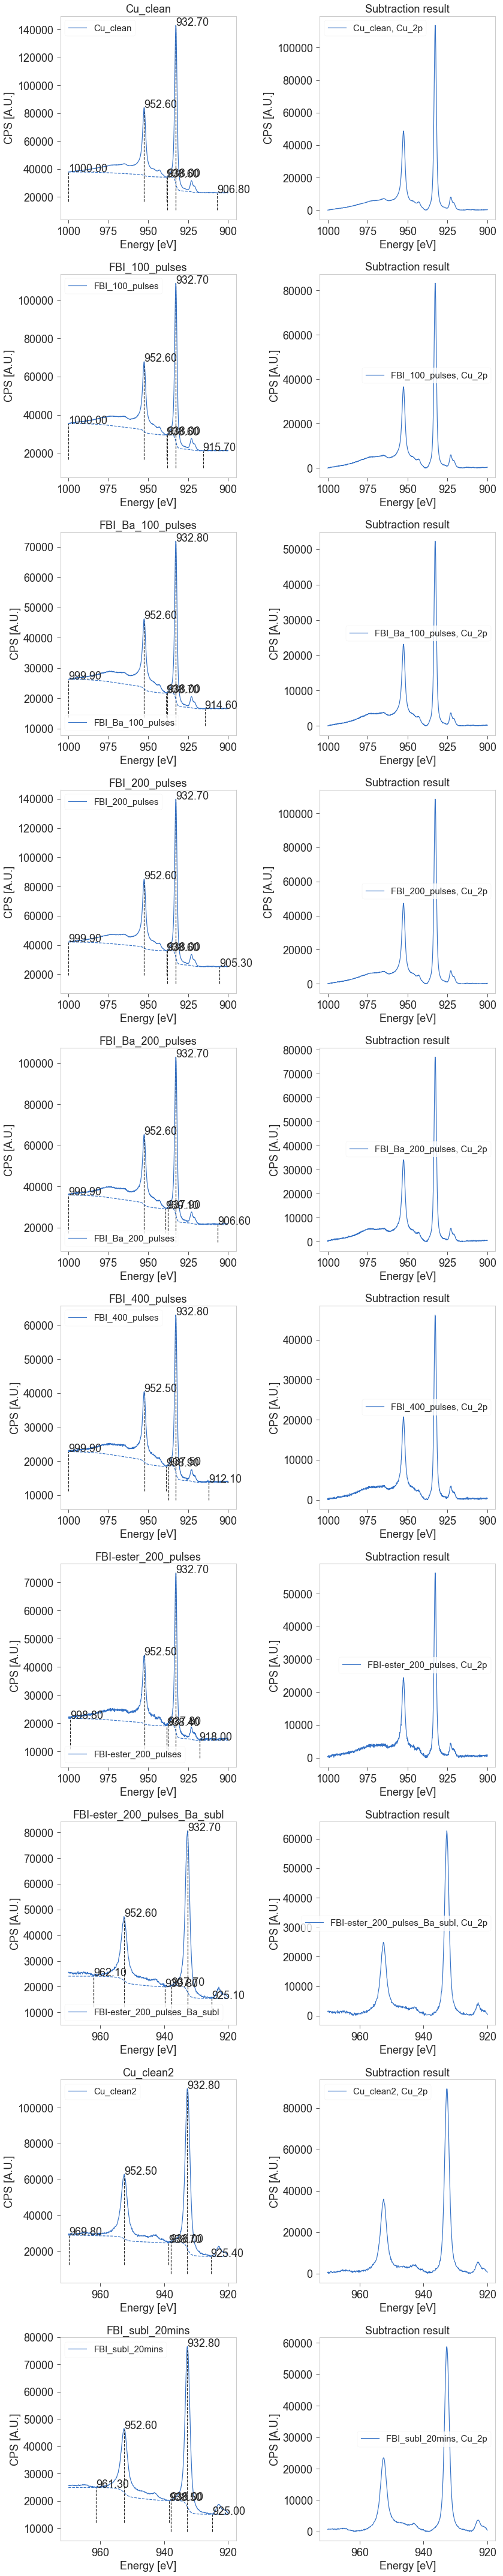

In [37]:
region = 'Cu_2p'

bg_exps = region_2bg_subtract(experiments, region=region, xlim=938)

### Bulk subtract background

Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline
Max iterations exceeded, subtract ALS baseline


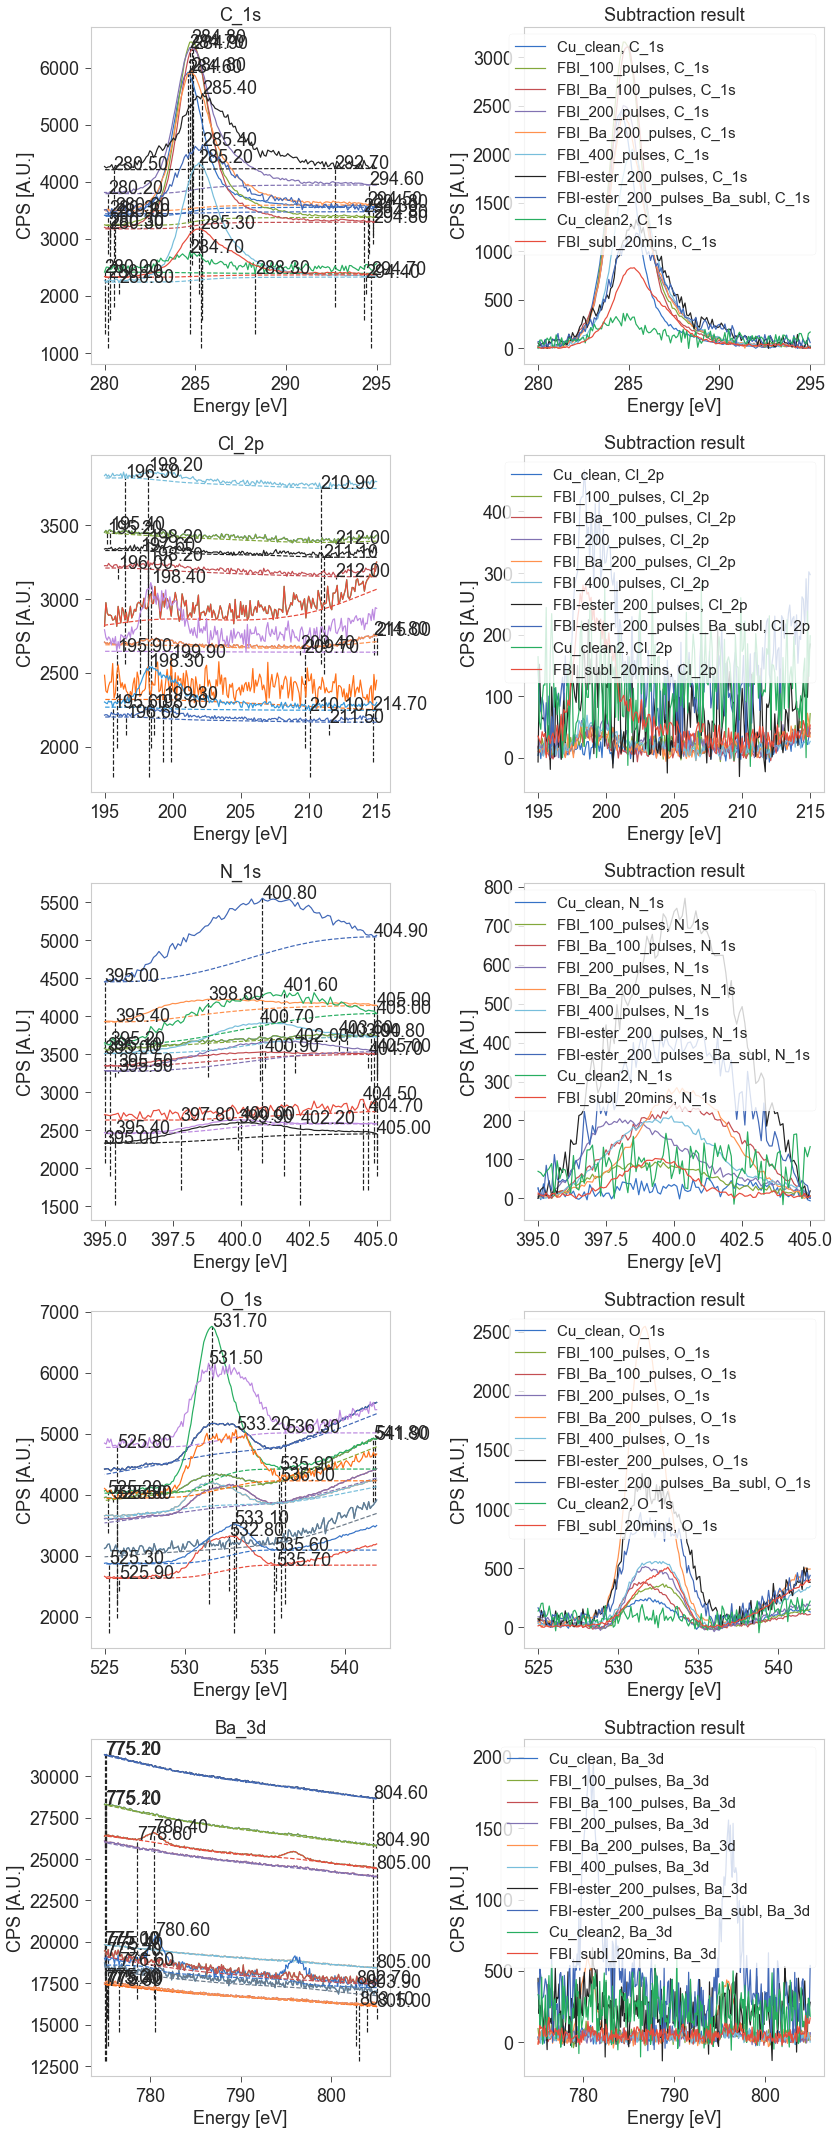

In [38]:
regions = ['C_1s', 'Cl_2p', 'N_1s', 'O_1s', 'Ba_3d']
bg_exps = bulk_bg_subtract(bg_exps, regions)

#### Plot result of bulk subtract

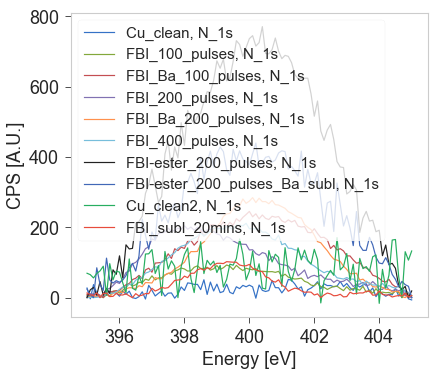

In [39]:
region = 'N_1s'
for xp in bg_exps:
    plot_region(xp, region)

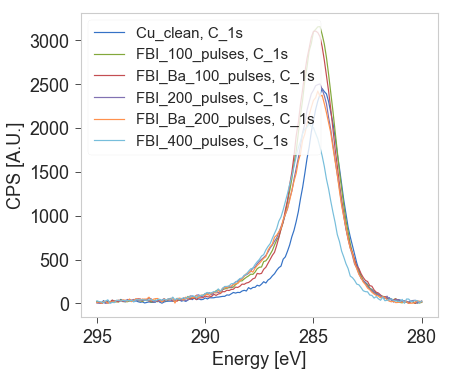

In [16]:
region = 'C_1s'
for xp in bg_exps:
    plot_region(xp, region)
cosmetics_plot()

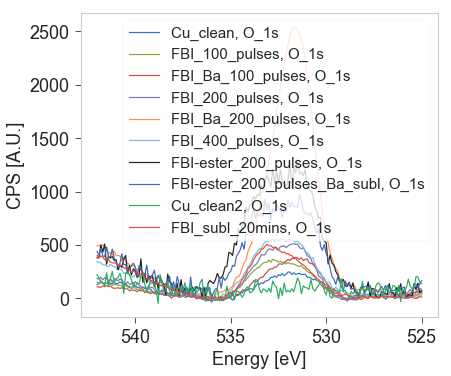

In [40]:
region = 'O_1s'
for xp in bg_exps:
    plot_region(xp, region)
cosmetics_plot()

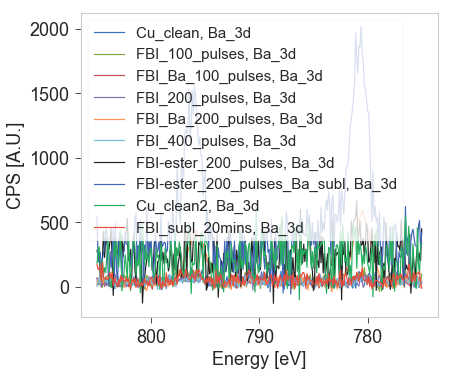

In [41]:
region = 'Ba_3d'
for xp in bg_exps:
    plot_region(xp, region)
cosmetics_plot()

### Subtract linear and shirley bg to all O 1s regions

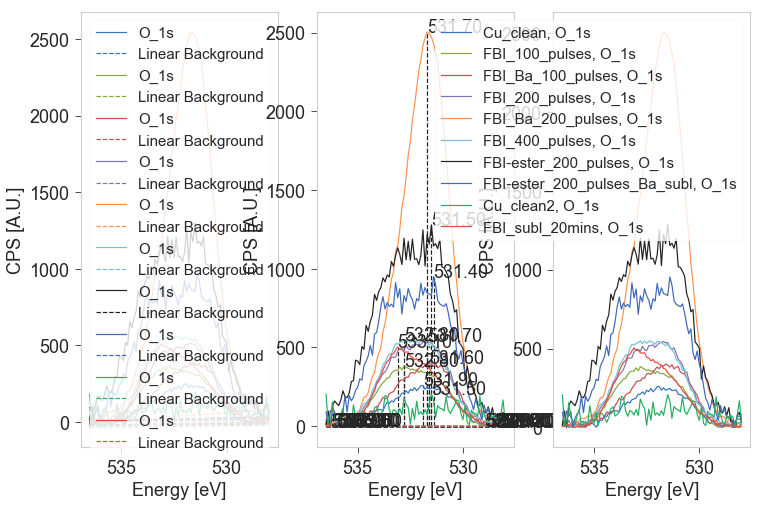

In [42]:
region = 'O_1s'
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
new_exps = []
for xp in bg_exps:
    xp_crop = crop_spectrum(xp, region, eup=536.5, edw=528)
    xp_lin = subtract_linear_bg(xp_crop, region, ax=ax[0])
    xp_bg = subtract_shirley_bg(xp_lin, region, maxit=40, ax=ax[1])
    plot_region(xp_bg, region, ax=ax[2])
    new_exps.append(xp_bg)
for i in range(3): cosmetics_plot(ax=ax[i])
bg_exps = new_exps

### Subtract linear and shirley bg to all Ba 3d regions

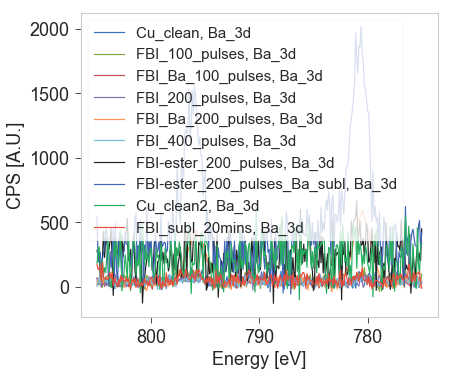

In [43]:
region = 'Ba_3d'
for xp in bg_exps:
    plot_region(xp, region)
cosmetics_plot()

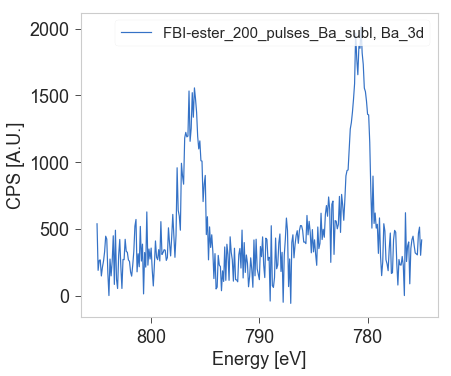

In [45]:
plot_region(bg_exps[-3], region)

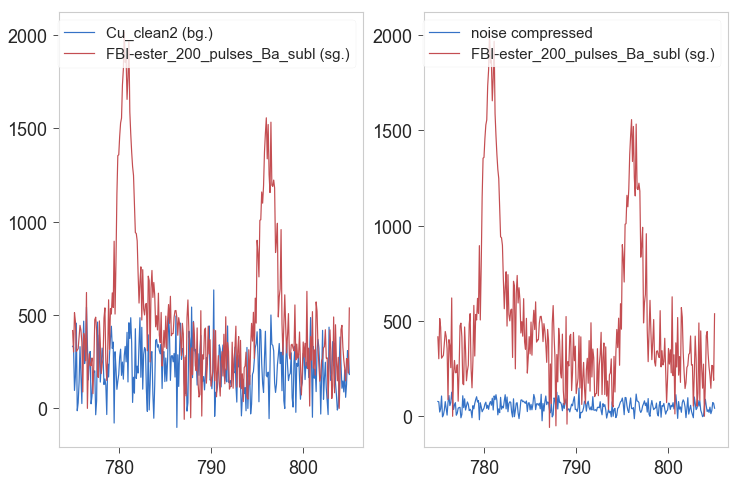

In [46]:
compress_noisy_region(bg_exps[-2], bg_exps[-3], region, inplace=True);

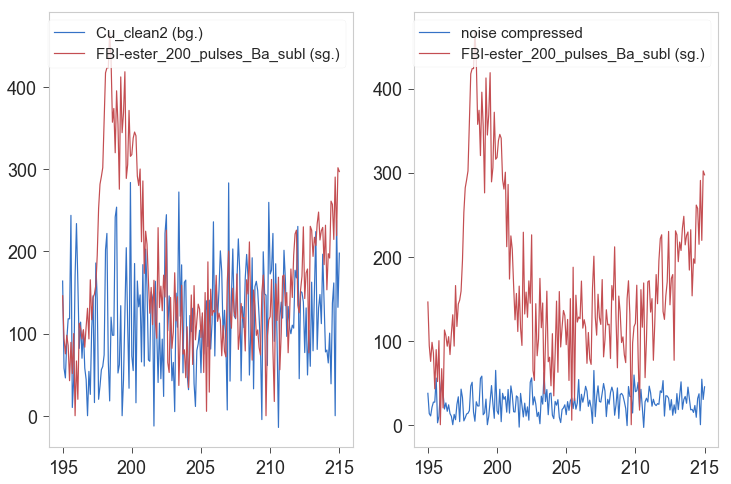

In [47]:
region= 'Cl_2p'
compress_noisy_region(bg_exps[-2], bg_exps[-3], region, inplace=True);

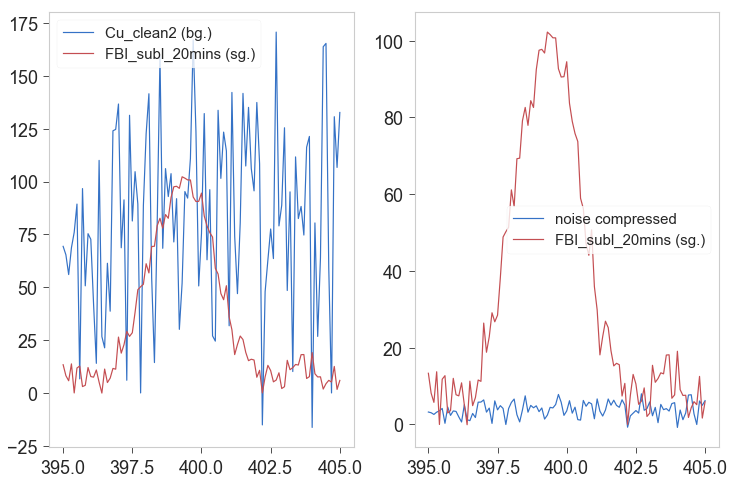

In [58]:
region= 'N_1s'
compress_noisy_region(bg_exps[-2], xpRef=bg_exps[-1], region=region, inplace=True);

In [84]:
bg_exps[4].dfx[region] = xp_bg.dfx[region]

In [85]:
bg_exps[4].dfx[region].max()

properties
energy    805.000000
counts    642.890574
dtype: float64

## Scale to Cu 2p

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


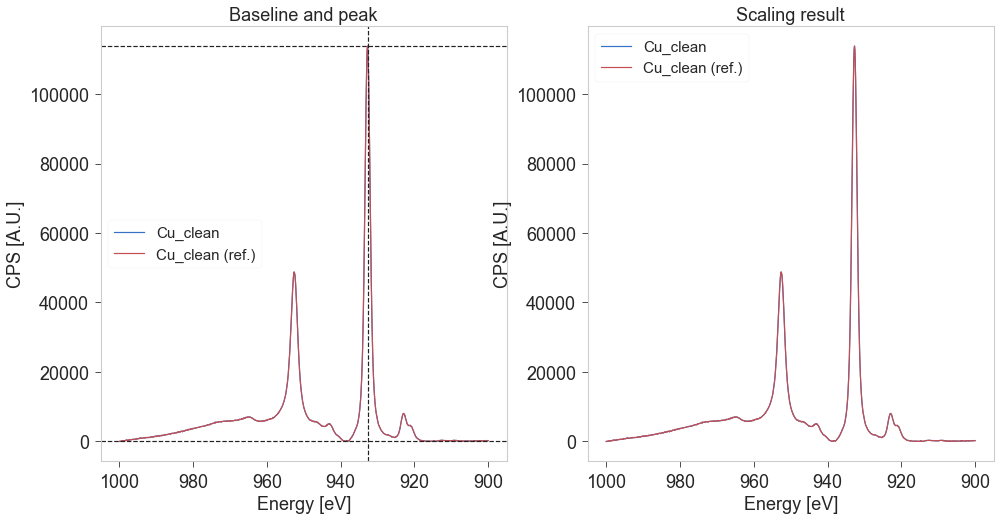

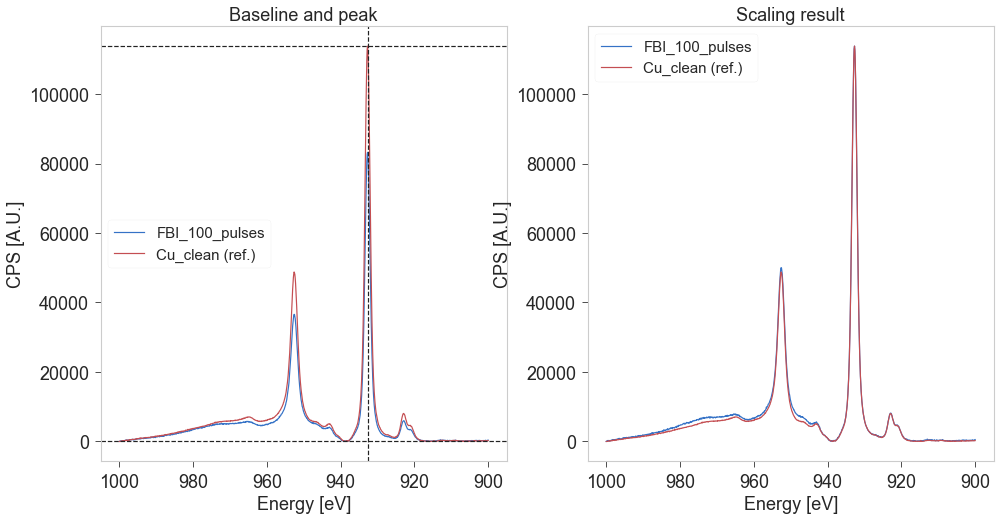

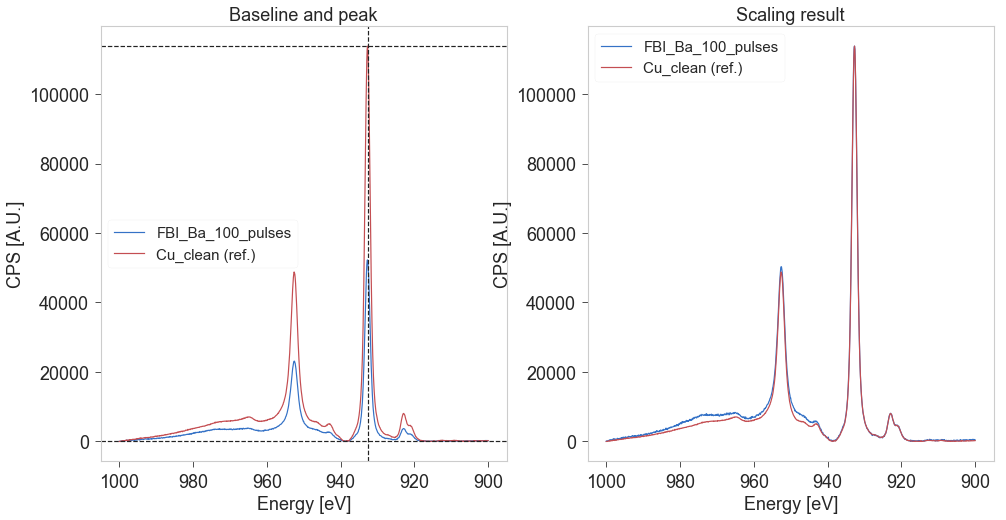

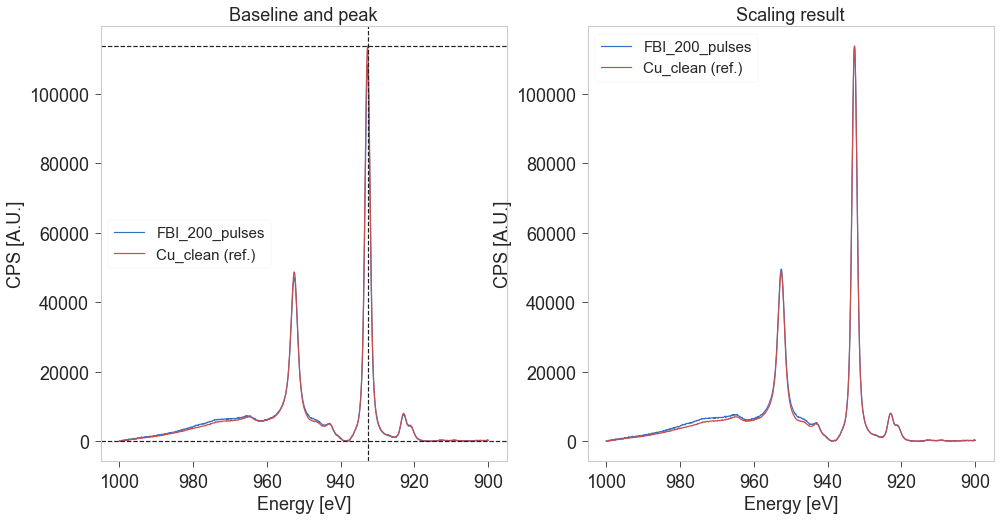

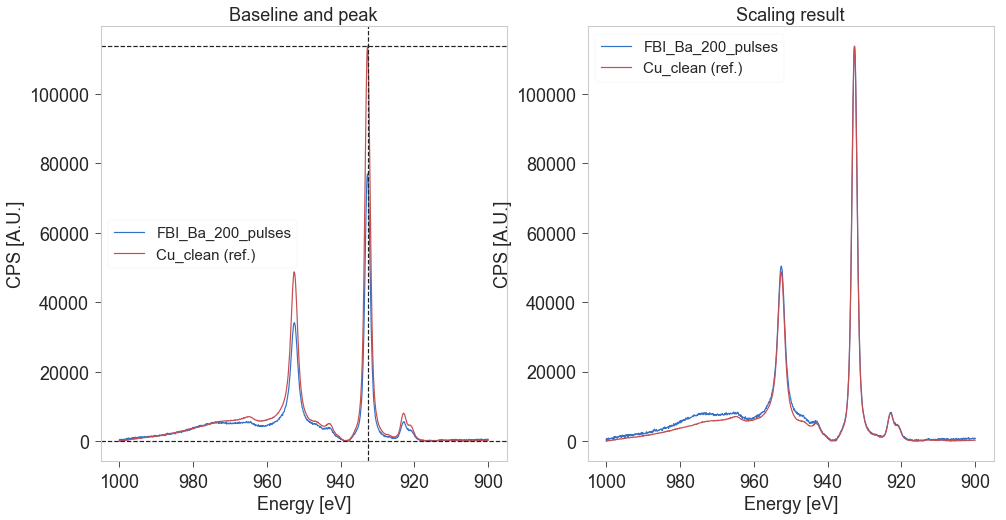

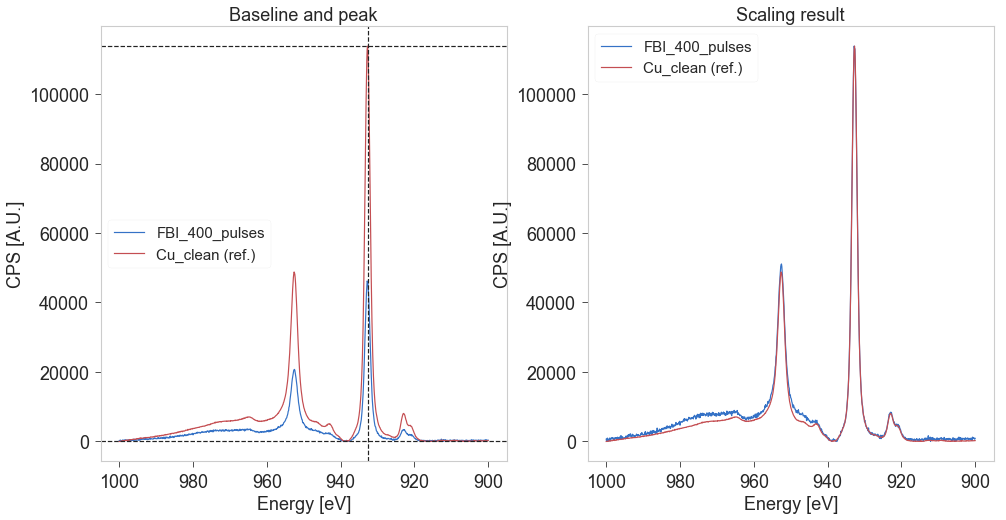

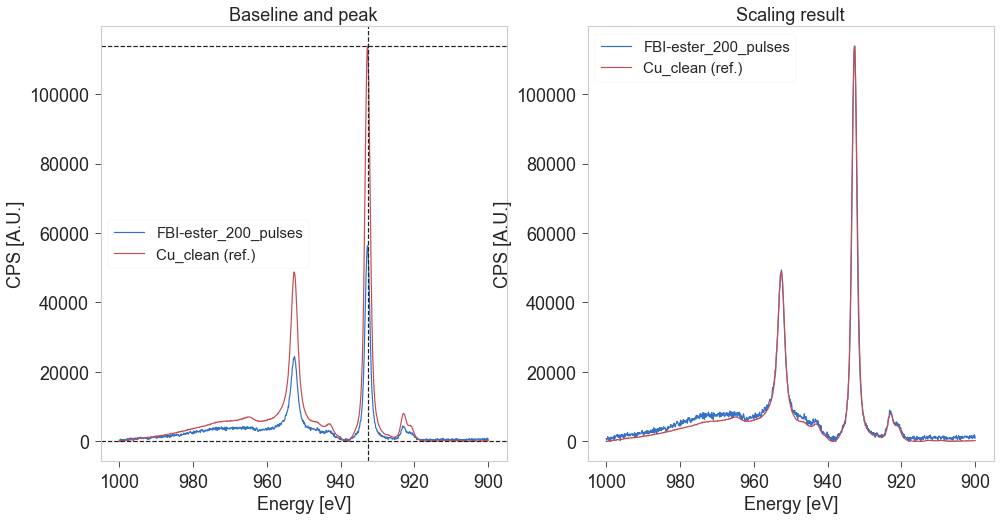

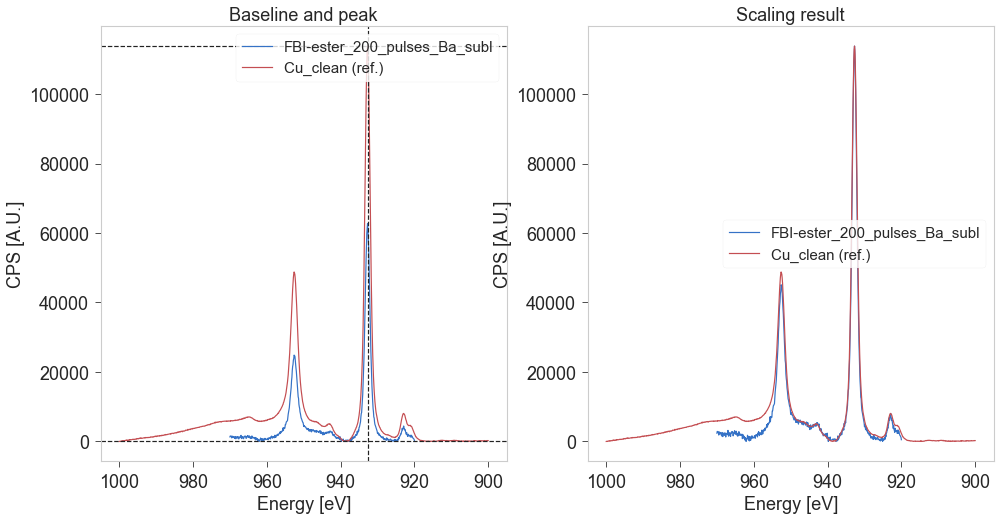

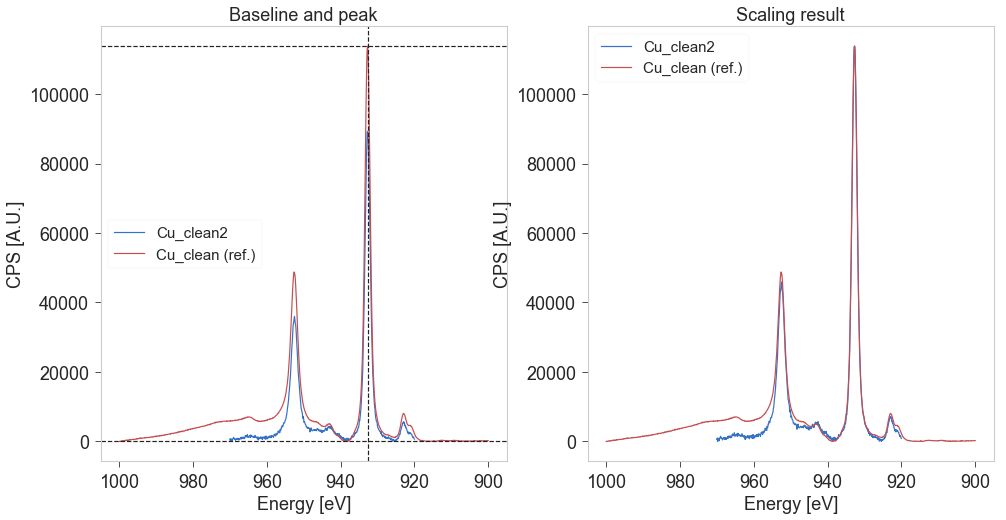

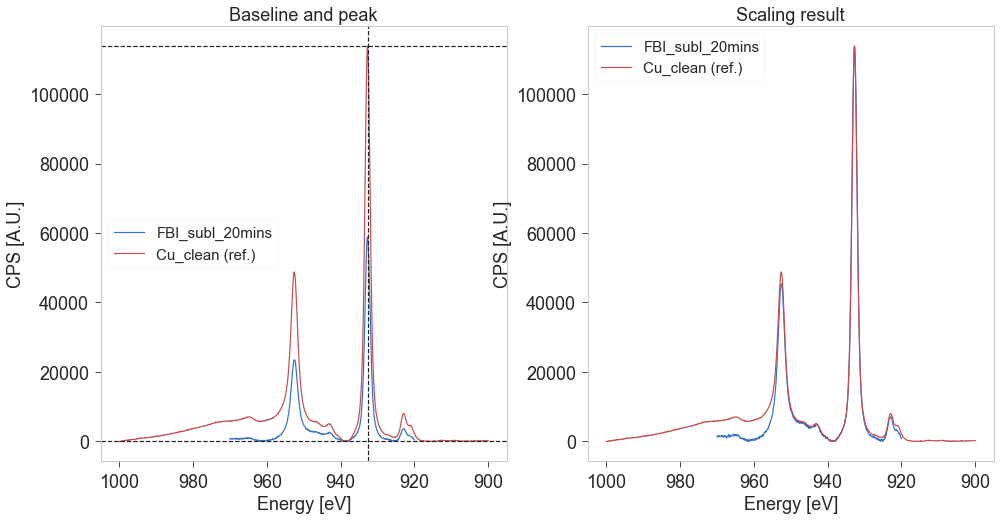

In [59]:
scaled_exps = []
for xpbg in bg_exps:
    scale = scale_and_plot_spectra(xp = xpbg, xpRef = bg_exps[0], region = 'Cu_2p')
    scaled_exps.append(scale_dfx(xp = xpbg, scale_factor = scale))

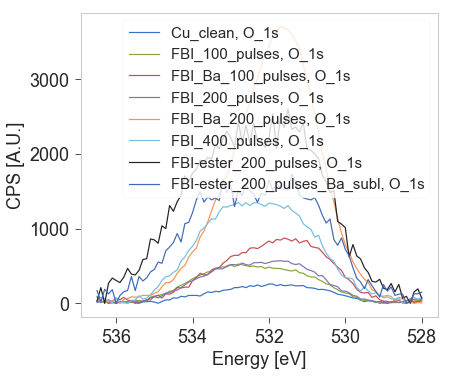

In [23]:
for xp in scaled_exps:
    plot_region(xp, 'O_1s')
cosmetics_plot()

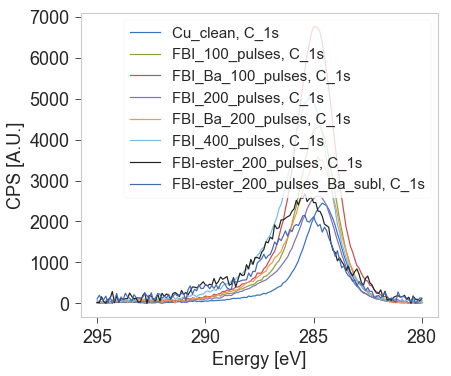

In [24]:
for xp in scaled_exps:
    plot_region(xp, 'C_1s')
cosmetics_plot()

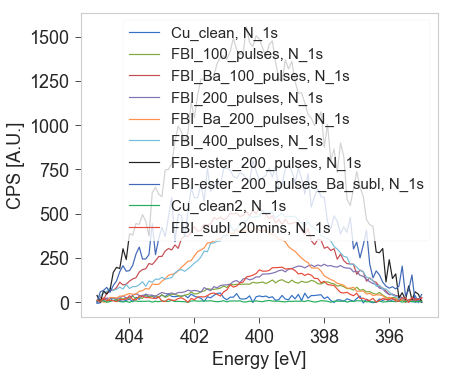

In [60]:
for xp in scaled_exps:
    plot_region(xp, 'N_1s')
cosmetics_plot()

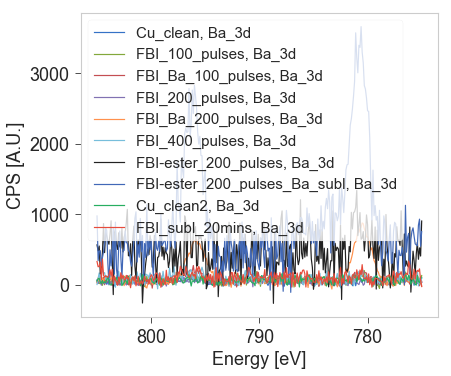

In [50]:
for xp in scaled_exps:
    plot_region(xp, 'Ba_3d')
cosmetics_plot()

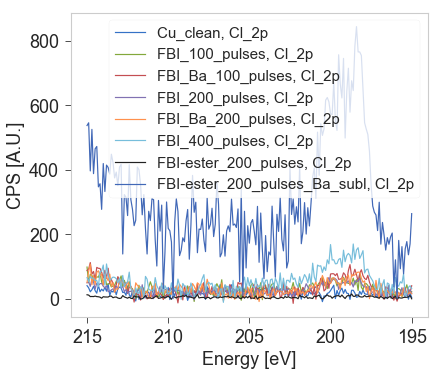

In [22]:
for xp in scaled_exps:
    plot_region(xp, 'Cl_2p')
cosmetics_plot()

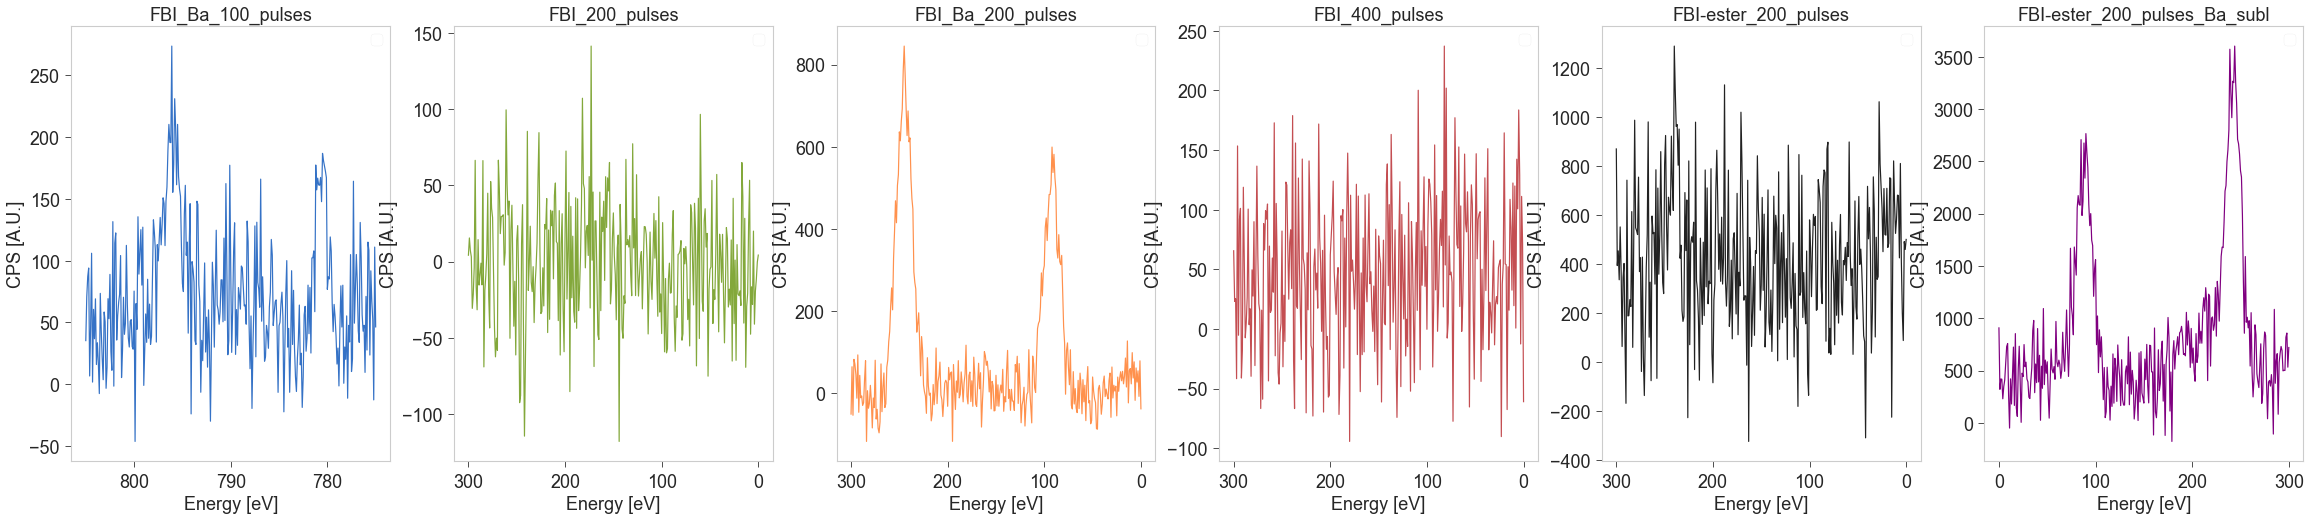

In [30]:
region = 'Ba_3d'
colors = ['b', 'g', 'y', 'r', 'k', 'purple']
fig, ax = plt.subplots(1, 6, figsize=(40, 8))
for i,xp in enumerate(scaled_exps[2:8]):
    if i == 0:   # Set labels from last region
        li = plot_region(xp, 'Ba_3d', ax=ax[i], lb='__nolabel__')
    else:
        dfsub = xp.dfx[region].counts-scaled_exps[0].dfx[region].counts
        li = ax[i].plot(dfsub, label='__nolabel__')[0]
    if len(colors) > 0: li.set_color(colors[i])
    ax[i].set_title(xp.name)
    cosmetics_plot(ax=ax[i])
# plt.tight_layout()

## Store processed experiments

In [62]:
import os
for xp, xpProc in zip(experiments, scaled_exps):
    filepath, filename = os.path.split(xp.path)
    newpath = filepath + '/proc/'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
#     print(newpath + filename)
    write_processed_xp(newpath + filename, xpProc)